In [24]:
from model import *
import csv

In [25]:
incomes  = []
counts = []

with open('incomes.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    for row in csv_reader:
        incomes.append([int(row[0])*1000/12,int(row[1])*1000/12])
        counts.append(int(row[2]))

cum_counts = []
for i in range(len(counts)):
    cum_counts.append(sum(counts[:i+1]))

hhld_count = sum(counts)

cum_ratios = [x / hhld_count for x in cum_counts]


In [26]:
model = HousingMarket(rental_cost = 2000, incomes=incomes, income_distr=cum_ratios)
model.run_model(20000)
data = model.datacollector.get_model_vars_dataframe()

<AxesSubplot:>

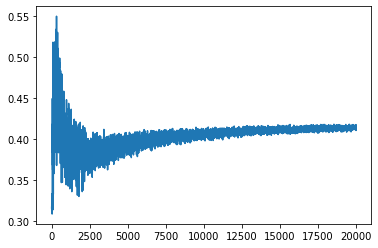

In [27]:
data["Gini"].plot()

In [5]:
model = HousingMarket(rental_cost = 10000)
model.run_model(1000)
data = model.datacollector.get_model_vars_dataframe()

<AxesSubplot:>

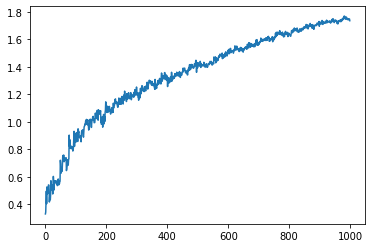

In [6]:
data["Gini"].plot()

In [4]:
model = HousingMarket(rental_cost = 10)
model.run_model(1000)
data = model.datacollector.get_model_vars_dataframe()

<AxesSubplot:>

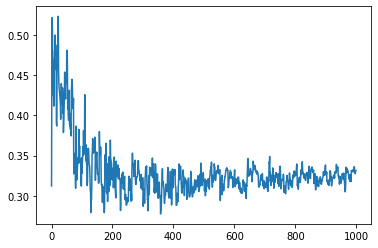

In [5]:
data["Gini"].plot()

In [6]:
model = HousingMarket(rental_cost = 1000)
model.run_model()
data = model.datacollector.get_model_vars_dataframe()

<AxesSubplot:>

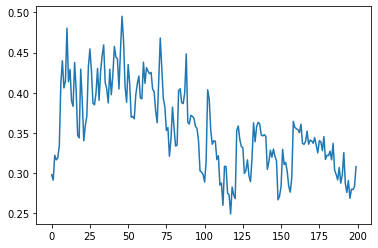

In [7]:
data["Gini"].plot()